# Assignment2

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import h3
from folium import Map, Marker, GeoJson
from folium.plugins import HeatMap
import branca.colormap as cm

## problem(1)

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [2]:
filename1 = 'datasets/data_offers.csv'
filename2 = 'datasets/data_orders.csv'
offers = pd.read_csv(filename1)
orders = pd.read_csv(filename2)
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'], format='%H:%M:%S')

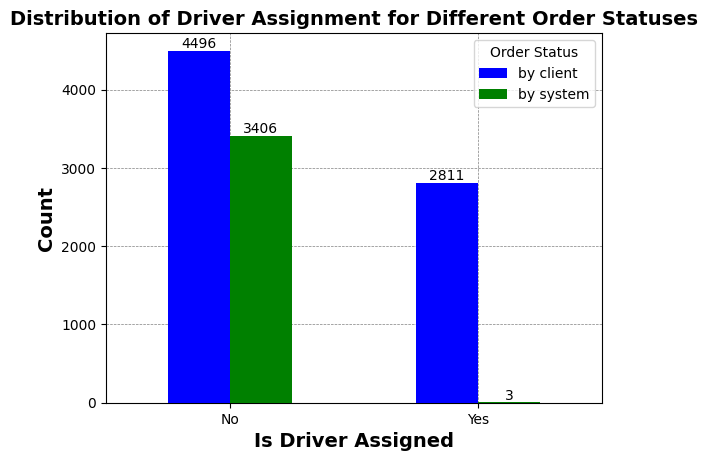

In [3]:
status_4_orders = orders[orders['order_status_key'] == 4]
status_9_orders = orders[orders['order_status_key'] == 9]

# 计算is_driver_assigned_key在这两种状态下的分布
status_4_distribution = status_4_orders['is_driver_assigned_key'].value_counts().sort_index()
status_9_distribution = status_9_orders['is_driver_assigned_key'].value_counts().sort_index()

# 为了保证条形图中0和1都显示出来，即使它们的数量为0
distribution = pd.DataFrame({
    'by client': status_4_distribution,
    'by system': status_9_distribution
}).fillna(0)

# 画图
ax = distribution.plot(kind='bar', color=['blue', 'green'], zorder=3)
plt.xlabel('Is Driver Assigned', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Driver Assignment for Different Order Statuses', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', zorder=0)
plt.legend(title='Order Status')

# 在柱状图上添加数值
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')



plt.show()

## problem(2)

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

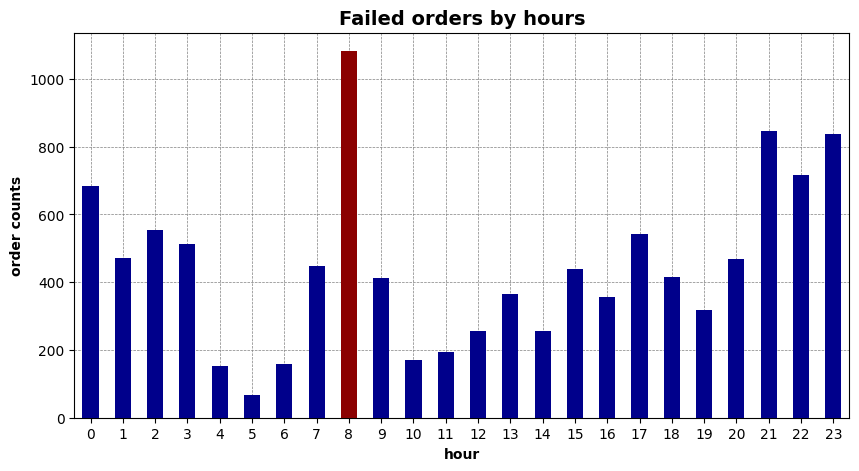

In [4]:
hourly_counts = orders['order_datetime'].dt.hour.value_counts().sort_index()

max_hourly_counts = hourly_counts.idxmax()
colors = ['darkblue' if (index !=max_hourly_counts) else 'darkred' for index in hourly_counts.index]
plt.figure(figsize=(10,5))
hourly_counts.plot(kind = 'bar',color = colors,zorder=3)

plt.xlabel('hour',fontweight='bold',fontsize=10)
plt.ylabel('order counts',fontweight='bold',fontsize=10)
plt.title('Failed orders by hours',fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', zorder=0)
plt.xticks(rotation = 0)
plt.show()

In [5]:
names = ['Driver is assign \ncancel by client','Driver not assign \ncancel by client','Driver is assign \ncancel by system','Driver not assign \ncancel by system']
Assigned_client = status_4_orders[status_4_orders['is_driver_assigned_key'] == 1]['order_datetime'].dt.hour.value_counts().sort_index()
notAssigned_client = status_4_orders[status_4_orders['is_driver_assigned_key'] == 0]['order_datetime'].dt.hour.value_counts().sort_index()
Assigned_system = status_9_orders[status_9_orders['is_driver_assigned_key'] == 1]['order_datetime'].dt.hour.value_counts().sort_index()
notAssigned_system = status_9_orders[status_9_orders['is_driver_assigned_key'] == 0]['order_datetime'].dt.hour.value_counts().sort_index()

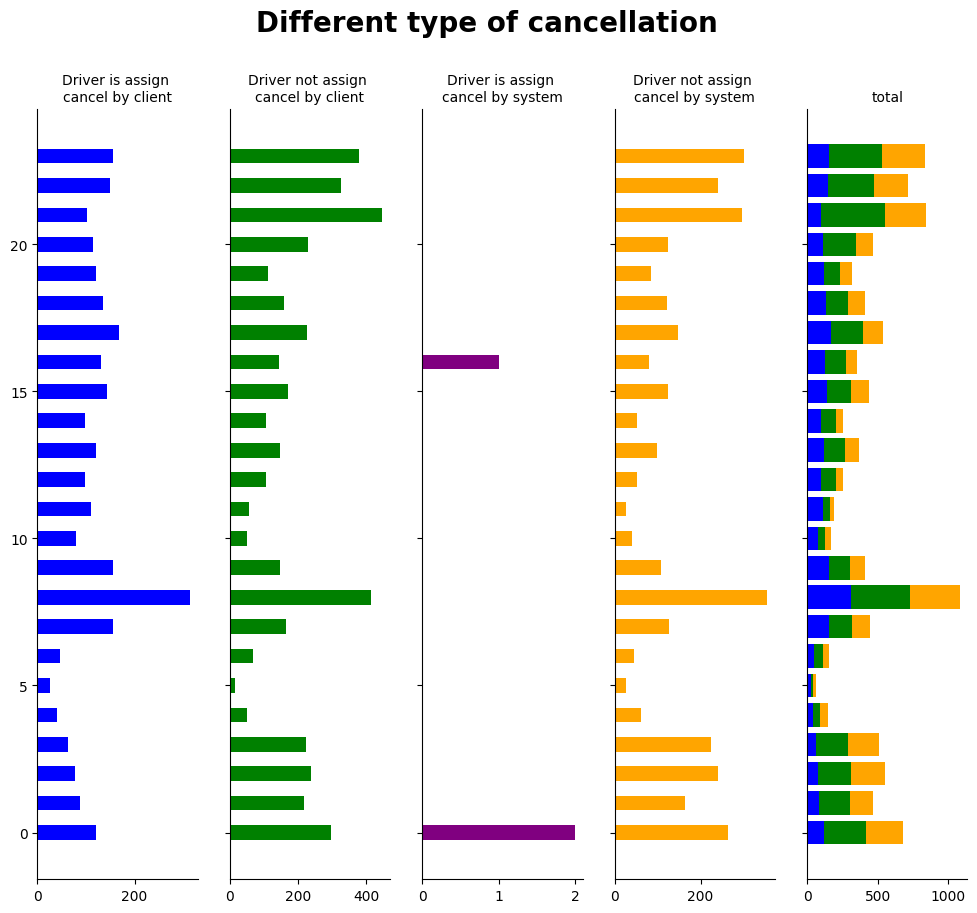

In [6]:
datalist = [Assigned_client,notAssigned_client,Assigned_system,notAssigned_system]
color_list = ['blue', 'green', 'purple', 'orange']

hours = range(24)
zero_data = np.zeros(len(hours))
new_datalist = []
for datas in datalist:
    new_data = pd.Series(np.zeros(len(hours)), index=hours)
    new_data.update(datas)
    new_datalist.append(new_data)
    
fig,axs = plt.subplots(1,5,figsize = (12,10),sharey=True)
for i,ax in enumerate(axs):
    if(i != 4):
        ax.barh(new_datalist[i].index,new_datalist[i],color=color_list[i],height=0.5)
        ax.set_title(names[i],fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        # 只显示左侧边框（纵轴）
        ax.spines['left'].set_visible(True)

        ax.tick_params(axis='y', labelsize=10)
    if(i == 4):
        lefts = np.zeros(len(new_datalist[0]))
        for j in (range(4)):
            ax.barh(new_datalist[j].index,new_datalist[j],left=lefts,color=color_list[j])
            lefts += new_datalist[j]
            ax.set_title('total',fontsize=10)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            
            ax.spines['left'].set_visible(True)
            
            ax.tick_params(axis='y', labelsize=10)
    

title = 'Different type of cancellation'
fig.suptitle(title, fontsize=20, weight='bold')

plt.show()

## problem(3)

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [7]:
temp_orders = orders[orders['cancellations_time_in_seconds'].notna()]
temp_orders_with = temp_orders[temp_orders['is_driver_assigned_key'] == 1].set_index('order_datetime')
temp_orders_without = temp_orders[temp_orders['is_driver_assigned_key'] == 0].set_index('order_datetime')
temp_orders_with_seconds_by_hour = temp_orders_with['cancellations_time_in_seconds'].resample('H').mean()
temp_orders_without_seconds_by_hour = temp_orders_without['cancellations_time_in_seconds'].resample('H').mean()

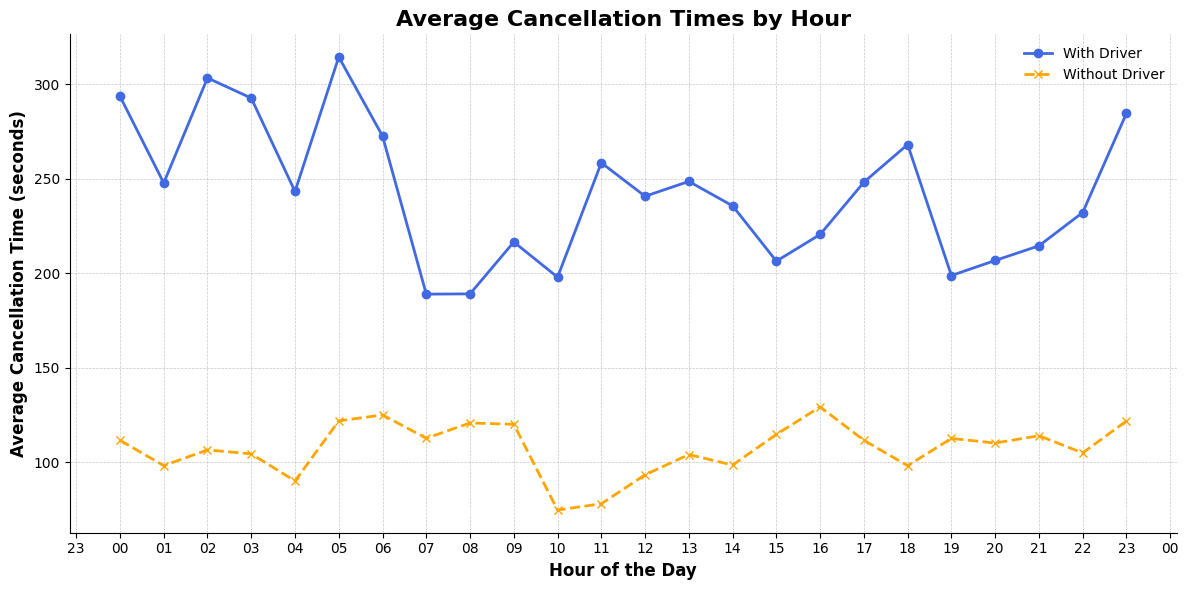

In [8]:
hours_fmt = mdates.DateFormatter('%H') 
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(temp_orders_with_seconds_by_hour.index, temp_orders_with_seconds_by_hour, label='With Driver', marker='o', linestyle='-', linewidth=2, color='royalblue')
ax.plot(temp_orders_without_seconds_by_hour.index, temp_orders_without_seconds_by_hour, label='Without Driver', marker='x', linestyle='--', linewidth=2, color='orange')

ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_major_locator(mdates.HourLocator())

ax.set_title('Average Cancellation Times by Hour', fontweight='bold', fontsize=16)
ax.set_xlabel('Hour of the Day', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Cancellation Time (seconds)', fontweight='bold', fontsize=12)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(frameon=False, fontsize=10, loc='upper right')

ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='y', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [9]:
def bound(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    return lower_bound,upper_bound

In [10]:
def draw_lines(df_with,df_without):
    hour_correspond_value_with = []
    hour_correspond_value_without = []
    hour_correspond_value_with_upper_bound = []
    hour_correspond_value_with_lower_bound = []
    hour_correspond_value_without_upper_bound = []
    hour_correspond_value_without_lower_bound = []
    
    for i in range(24):
        hourly_temp_orders_with=df_with[df_with['order_datetime'].dt.hour == i]
        hourly_temp_orders_without=df_without[df_without['order_datetime'].dt.hour == i]
        
        hour_correspond_value_with.append(hourly_temp_orders_with['cancellations_time_in_seconds'].mean())
        hour_correspond_value_without.append(hourly_temp_orders_without['cancellations_time_in_seconds'].mean())
        lower_bound,upper_bound = bound(hourly_temp_orders_with,'cancellations_time_in_seconds')
        hour_correspond_value_with_upper_bound.append(upper_bound)
        hour_correspond_value_with_lower_bound.append(lower_bound)
        lower_bound,upper_bound = bound(hourly_temp_orders_without,'cancellations_time_in_seconds')
        hour_correspond_value_without_upper_bound.append(upper_bound)
        hour_correspond_value_without_lower_bound.append(lower_bound)
    x = list(range(24))

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(x, hour_correspond_value_with, label='With Driver', marker='o', linestyle='-', linewidth=2, color='royalblue')
    ax.fill_between(x, hour_correspond_value_with_lower_bound, hour_correspond_value_with_upper_bound, color='royalblue', alpha=0.2)

    ax.plot(x, hour_correspond_value_without, label='With Driver', marker='x', linestyle='--', linewidth=2, color='orange')
    ax.fill_between(x, hour_correspond_value_without_lower_bound, hour_correspond_value_without_upper_bound, color='orange', alpha=0.2)

    ax.set_title('Average Cancellation Times by Hour', fontweight='bold', fontsize=16)
    ax.set_xlabel('Hour of the Day', fontweight='bold', fontsize=12)
    ax.set_ylabel('Average Cancellation Time (seconds)', fontweight='bold', fontsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(frameon=False, fontsize=10, loc='upper right')

    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()
        

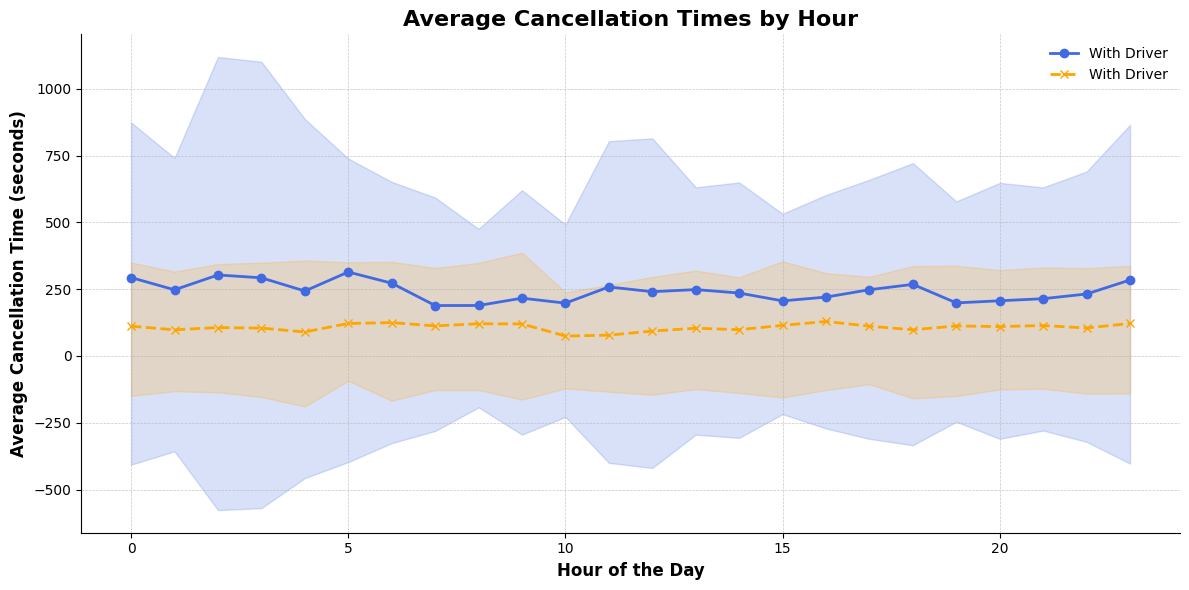

In [11]:
temp_orders = orders[orders['cancellations_time_in_seconds'].notna()]
temp_orders_with = temp_orders[temp_orders['is_driver_assigned_key'] == 1]
temp_orders_without = temp_orders[temp_orders['is_driver_assigned_key'] == 0]
draw_lines(temp_orders_with,temp_orders_without)

In [12]:
def Remove_outlier(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

In [13]:
temp_orders = orders[orders['cancellations_time_in_seconds'].notna()]
temp_orders_with = temp_orders[temp_orders['is_driver_assigned_key'] == 1].set_index('order_datetime')
temp_orders_without = temp_orders[temp_orders['is_driver_assigned_key'] == 0].set_index('order_datetime')

remove_with = Remove_outlier(temp_orders_with,'cancellations_time_in_seconds')
remove_without = Remove_outlier(temp_orders_without,'cancellations_time_in_seconds')
remove_with_seconds_by_hour = remove_with['cancellations_time_in_seconds'].resample('H').mean()
remove_without_seconds_by_hour = remove_without['cancellations_time_in_seconds'].resample('H').mean()

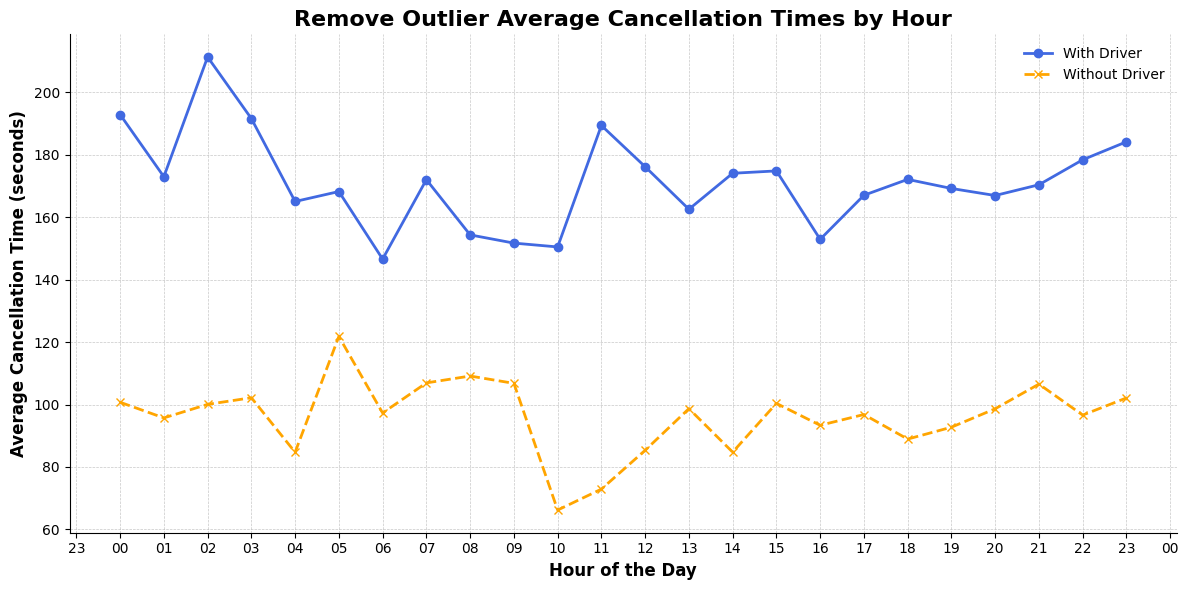

In [14]:
hours_fmt = mdates.DateFormatter('%H') 
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(remove_with_seconds_by_hour.index, remove_with_seconds_by_hour, label='With Driver', marker='o', linestyle='-', linewidth=2, color='royalblue')
ax.plot(remove_without_seconds_by_hour.index, remove_without_seconds_by_hour, label='Without Driver', marker='x', linestyle='--', linewidth=2, color='orange')

ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_major_locator(mdates.HourLocator())

ax.set_title('Remove Outlier Average Cancellation Times by Hour', fontweight='bold', fontsize=16)
ax.set_xlabel('Hour of the Day', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Cancellation Time (seconds)', fontweight='bold', fontsize=12)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(frameon=False, fontsize=10, loc='upper right')

ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='y', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## problem(4)

Plot the distribution of average ETA by hours. How can this plot be explained?

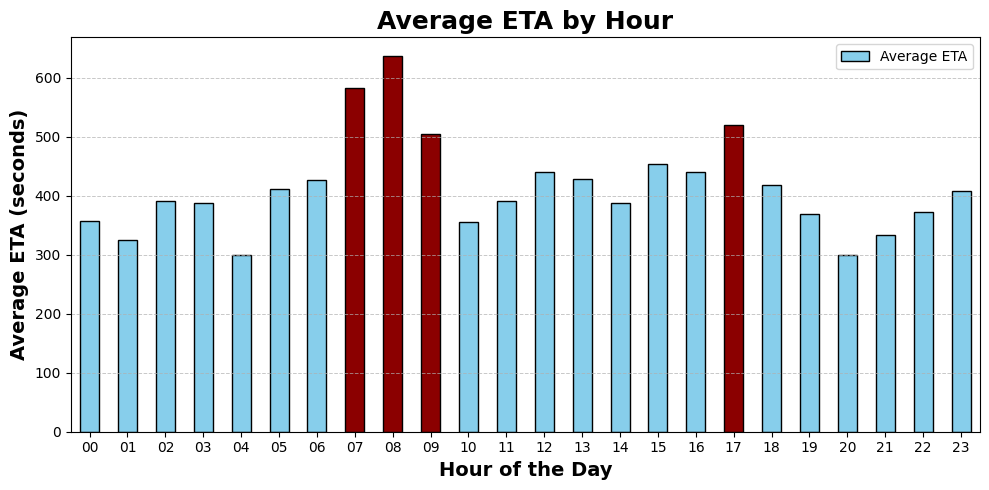

In [15]:
temp_ETA = orders[orders['m_order_eta'].notna()].set_index('order_datetime')
eta_by_hour = temp_ETA['m_order_eta'].resample('H').mean()
eta_by_hour.index = eta_by_hour.index.strftime('%H')
colors = ['darkred' if (value > 500) else 'skyblue' for value in eta_by_hour]
plt.figure(figsize=(10, 5))
eta_by_hour.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average ETA by Hour', fontsize=18, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=14, fontweight='bold')
plt.ylabel('Average ETA (seconds)', fontsize=14, fontweight='bold')
plt.legend(['Average ETA'])
plt.xticks(rotation = 0)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

## problem(5)

BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [17]:
import pandas as pd
import h3
import folium
from branca.colormap import linear

orders['h3_index'] = orders.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

order_counts = orders['h3_index'].value_counts()

# 计算总订单数量的80%
total_orders_80_percent = order_counts.sum() * 0.8

# 找出包含80%订单的h3索引
cumulative_orders = 0
h3_indexes_80_percent = []
for h3_index, count in order_counts.iteritems():
    cumulative_orders += count
    h3_indexes_80_percent.append(h3_index)
    if cumulative_orders >= total_orders_80_percent:
        break

# 生成地图的中心点
center_latitude = orders['origin_latitude'].mean()
center_longitude = orders['origin_longitude'].mean()

# 创建地图对象
map = folium.Map(location=[center_latitude, center_longitude], zoom_start=12)

# 定义颜色映射
colormap = linear.YlOrRd_09.scale(min(order_counts), max(order_counts))
map.add_child(colormap)

# 为每个h3索引添加六边形到地图
for h3_index in h3_indexes_80_percent:
    # 获取该h3索引的六边形边界
    boundary = h3.h3_to_geo_boundary(h3_index, geo_json=True)
    # 获取订单数量，用于颜色映射
    
    # 创建GeoJson对象并添加到地图
    geo_json = folium.GeoJson(
        data={
            "type": "Polygon",
            "coordinates": [boundary]
        },
        style_function = lambda x, count=order_counts[h3_index]: {
            'fillColor': colormap(count),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.75
        }
    ).add_to(map)

# 保存到HTML文件
map.save('h3_map.html')


/tmp/ipykernel_9639/2377036627.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for h3_index, count in order_counts.iteritems():
